In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from forecasting import SalesForecaster
from IPython.display import clear_output
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_windows
from tqdm.auto import tqdm

In [ ]:
# Объект главного класса для работы с прогнозированием
main_class = SalesForecaster()

# Подготовка данных

Подготовим данные для работы.  
Работаем с магазином STORE_1.  

Сделаем разбиение на train_val и test части.  

Временной диапазон длительный (почти 5 лет). Поэтому по идее мы даже сможем захватить годовую сезонность (так как для "захвата" сезонности требуется, чтобы было хотя бы 2 периода в train сплите).

План по сплиту данных: 
* train: фиксированно возьмем 2 года - сразу до val сплита
* val: пред-последний 1 год - чтобы валидировать работу модели на разных месяцах
* test: последние 4 месяца (квартал) - построим прогноз на последнюю неделю, месяц, квартал

In [ ]:
print(main_class.prepare_data.__doc__)
main_class.prepare_data(Path("../data"), store_id="STORE_1")


        Prepares the data for forecasting:
        - Loads sales, dates, prices data from CSV files.
        - Selects data for the specified store.
        - Merges the data into a single DataFrame.
        - Make training, validation, and test splits of sizes (2 years, 1 year, 4 months).
        - Saves the splits to CSV files with names: <store_id>_<item_id>_train_val.csv and <store_id>_<item_id>_test.csv.
        


Теперь все сплиты по каждому товару для магазина STORE_1 находятся в одной папке.

In [ ]:
sorted(file.name for file in Path("../data").iterdir() if file.name.startswith("STORE_1"))

['STORE_1_STORE_1_064_test.csv',
 'STORE_1_STORE_1_064_train_val.csv',
 'STORE_1_STORE_1_065_test.csv',
 'STORE_1_STORE_1_065_train_val.csv',
 'STORE_1_STORE_1_090_test.csv',
 'STORE_1_STORE_1_090_train_val.csv',
 'STORE_1_STORE_1_252_test.csv',
 'STORE_1_STORE_1_252_train_val.csv',
 'STORE_1_STORE_1_325_test.csv',
 'STORE_1_STORE_1_325_train_val.csv',
 'STORE_1_STORE_1_339_test.csv',
 'STORE_1_STORE_1_339_train_val.csv',
 'STORE_1_STORE_1_376_test.csv',
 'STORE_1_STORE_1_376_train_val.csv',
 'STORE_1_STORE_1_546_test.csv',
 'STORE_1_STORE_1_546_train_val.csv',
 'STORE_1_STORE_1_547_test.csv',
 'STORE_1_STORE_1_547_train_val.csv',
 'STORE_1_STORE_1_555_test.csv',
 'STORE_1_STORE_1_555_train_val.csv',
 'STORE_1_STORE_1_584_test.csv',
 'STORE_1_STORE_1_584_train_val.csv',
 'STORE_1_STORE_1_586_test.csv',
 'STORE_1_STORE_1_586_train_val.csv',
 'STORE_1_STORE_1_587_test.csv',
 'STORE_1_STORE_1_587_train_val.csv',
 'STORE_1_STORE_1_714_test.csv',
 'STORE_1_STORE_1_714_train_val.csv',
 'STOR

Посмотрим на ВР для товара 727:

In [ ]:
train_val = pd.read_csv(Path("../data/STORE_1_STORE_1_727_train_val.csv"))
train_val.date = pd.to_datetime(train_val.date)
train_val.head()

,item_id,date_id,cnt,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,CASHBACK,sell_price
0,STORE_1_727,604,0,2012-09-23,11235,Sunday,2,9,2012,NaN,NaN,NaN,NaN,0,3.98
1,STORE_1_727,605,2,2012-09-24,11235,Monday,3,9,2012,NaN,NaN,NaN,NaN,0,3.98
2,STORE_1_727,606,5,2012-09-25,11235,Tuesday,4,9,2012,NaN,NaN,NaN,NaN,0,3.98
3,STORE_1_727,607,2,2012-09-26,11235,Wednesday,5,9,2012,NaN,NaN,NaN,NaN,0,3.98
4,STORE_1_727,608,0,2012-09-27,11235,Thursday,6,9,2012,NaN,NaN,NaN,NaN,0,3.98


In [ ]:
train_val.date.min(), train_val.date.max()

(Timestamp('2012-09-23 00:00:00'), Timestamp('2015-09-23 00:00:00'))

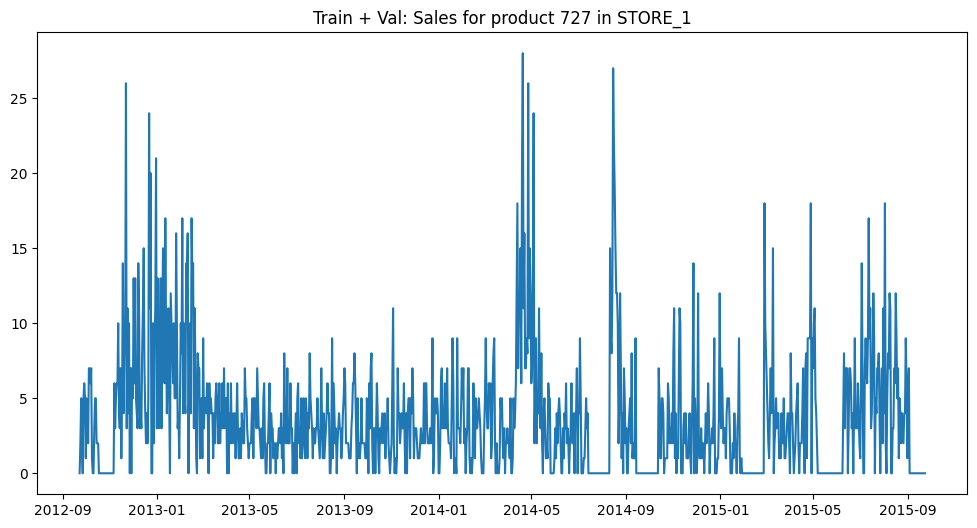

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_val.date, train_val.cnt)
plt.title("Train + Val: Sales for product 727 in STORE_1")
plt.show()

In [ ]:
test = pd.read_csv(Path("../data/STORE_1_STORE_1_727_test.csv"))
test.date = pd.to_datetime(test.date)
test.head()

,item_id,date_id,cnt,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,CASHBACK,sell_price
0,STORE_1_727,1700,0,2015-09-24,11534,Thursday,6,9,2015,EidAlAdha,Religious,NaN,NaN,0,3.33
1,STORE_1_727,1701,0,2015-09-25,11534,Friday,7,9,2015,NaN,NaN,NaN,NaN,0,3.33
2,STORE_1_727,1702,0,2015-09-26,11535,Saturday,1,9,2015,NaN,NaN,NaN,NaN,0,3.33
3,STORE_1_727,1703,0,2015-09-27,11535,Sunday,2,9,2015,NaN,NaN,NaN,NaN,0,3.33
4,STORE_1_727,1704,0,2015-09-28,11535,Monday,3,9,2015,NaN,NaN,NaN,NaN,0,3.33


In [ ]:
test.date.min(), test.date.max()

(Timestamp('2015-09-24 00:00:00'), Timestamp('2016-01-21 00:00:00'))

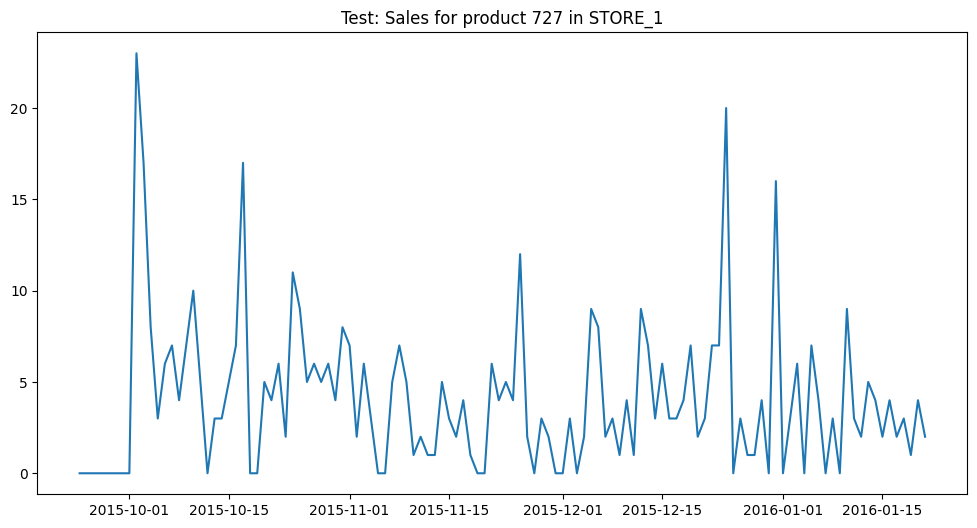

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test.date, test.cnt)
plt.title("Test: Sales for product 727 in STORE_1")
plt.show()

In [ ]:
# Вспомогательные переменные
ITEM_IDS = [
    "STORE_1_064",
    "STORE_1_065",
    "STORE_1_090",
    "STORE_1_252",
    "STORE_1_325",
    "STORE_1_339",
    "STORE_1_376",
    "STORE_1_546",
    "STORE_1_547",
    "STORE_1_555",
    "STORE_1_584",
    "STORE_1_586",
    "STORE_1_587",
    "STORE_1_714",
    "STORE_1_727",
]
ITEM_ID_2_TRAIN_VAL_TEST = {
    item_id: (
        pd.read_csv(Path(f"../data/STORE_1_{item_id}_train_val.csv")),
        pd.read_csv(Path(f"../data/STORE_1_{item_id}_test.csv")),
    )
    for item_id in ITEM_IDS
}

# Про метрики

В качестве метрик возьму следующие:
* MAE - стандартная метрика регресии, при аггрегации между разными ВР (а у нас у разных ВР разный масштаб продаж) необходимо взвешивание
* SMAPE - симметричный вариант процентной ошибки, более репрезентативные значения (у MAE это совсем не так). SMAPE хороша тут еще потому что у нас бывают нули во ВР.
* R2 - интересно сравнивать предсказания наших моделей со средним предсказанием

Соответственно итоговое качество модели мы будем оценивать на отложенной выборке размера 120 дней (будем проверять прогнозы на неделю, месяц, квартал).  
Для разных горизонтов прогнозирования из тестовой выборки берутся соответствующие части:
- горизонт 7 дней: беру первые 7 дней из тестовой выборки,
- горизонт 30 дней: беру первые 30 дней из тестовой выборки,
- горизонт 120 дней: беру всю тестовую выборку (она 120 дней).

Это сделано так, так как финальная модель обучается на последних 2 годах данных, не включая тестовую выборку (120 дней).

# Про кросс-валидацию

Для подбора гиперпараметров использую time-series cross-validation.  
Буду обучать 3 отдельных модели для разных горизонтов прогнозирования: 7 дней, 30 дней и 120 дней. Для каждого горизонта будет свой шаг скользящего окна, чтобы получить ровно 10 train-val сплитов:
* для горизонта 7 дней: шаг 38 дней,
* для горизонта 30 дней: шаг 35 дней,
* для горизонта 120 дней: шаг 25 дней.

Таким образом, для каждого горизонта будет проведено по 10 train-val разбиений для оценки качества модели.

То есть для каждого набора параметров будем обучать модель на 10 наборах train-val и в качестве итоговой модели будем брать модель обученную на последних 2-х годах данных.

Провизуализируем CV сплиты.

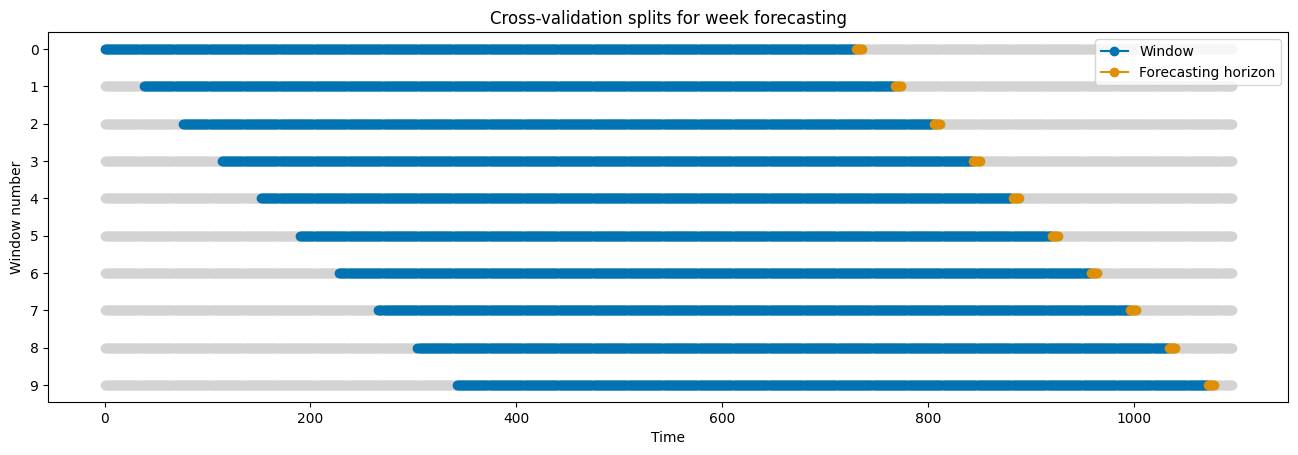

In [ ]:
cv = SlidingWindowSplitter(fh=np.arange(1, 8), window_length=365 * 2, step_length=38)
plot_windows(cv, train_val.cnt)
plt.title("Cross-validation splits for week forecasting")
plt.show()

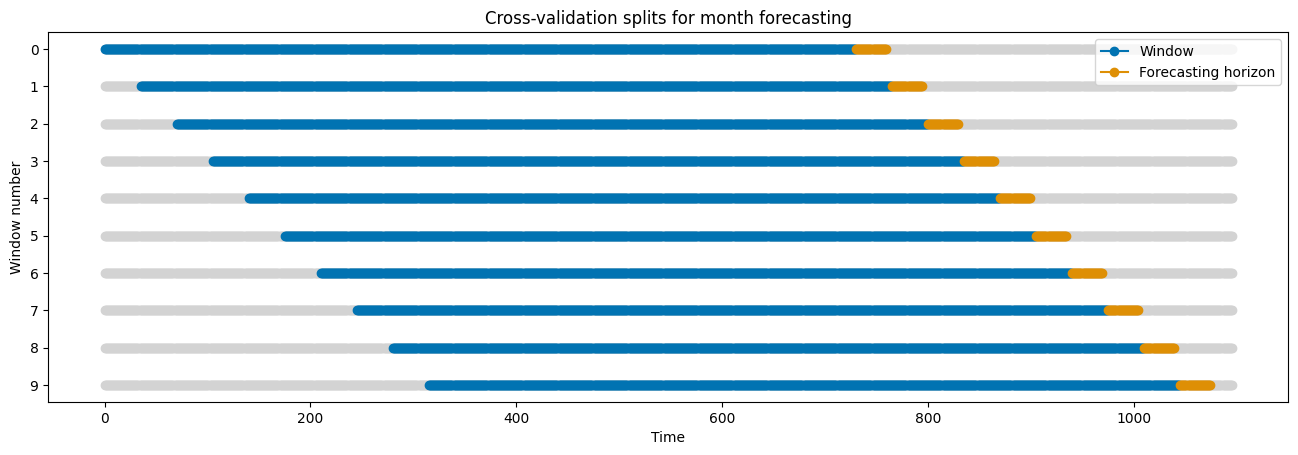

In [ ]:
cv = SlidingWindowSplitter(fh=np.arange(1, 31), window_length=365 * 2, step_length=35)
plot_windows(cv, train_val.cnt)
plt.title("Cross-validation splits for month forecasting")
plt.show()

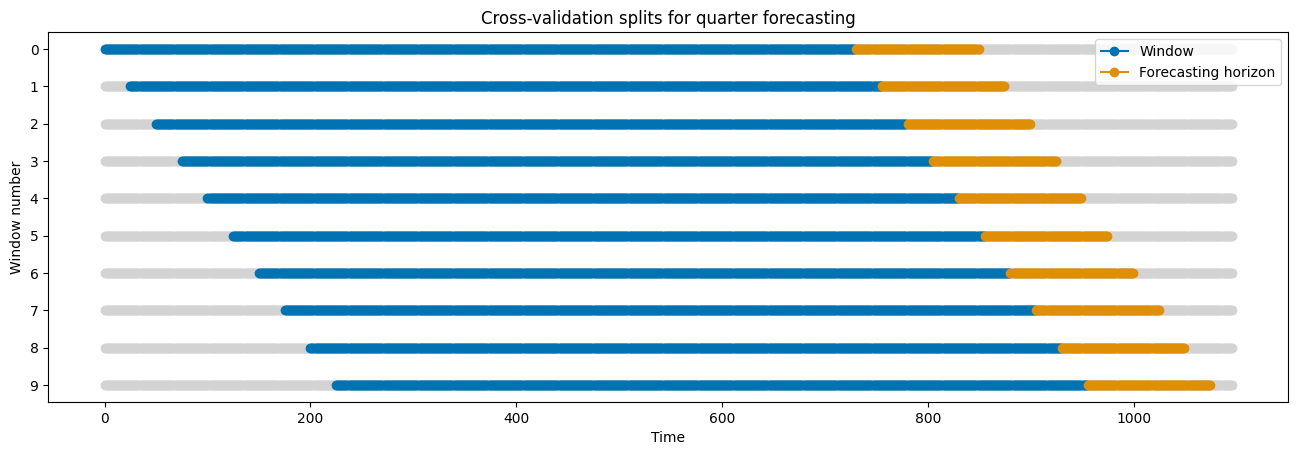

In [ ]:
cv = SlidingWindowSplitter(fh=np.arange(1, 121), window_length=365 * 2, step_length=25)
plot_windows(cv, train_val.cnt)
plt.title("Cross-validation splits for quarter forecasting")
plt.show()

# Наивные модели

Попробуем наивные модели из sktime NaiveForecaster:
* last (подберем параметр sp (seasonal periodicity) на CV)
* mean (подберем параметры sp и window_length на CV)
* drift (доп параметров нет)

In [ ]:
forecaster = NaiveForecaster(strategy="last")
param_grid = {"sp": [7, 14, 30, 60, 90, 120, 365]}
fh = 7

for item_id in tqdm(ITEM_IDS, desc="Cross-validating forecasters for each item", leave=False):
    gscv, best_forecaster = main_class.cross_validate_forecaster(
        forecaster=forecaster.clone(),
        train_val=ITEM_ID_2_TRAIN_VAL_TEST[item_id][0],
        param_grid=param_grid,
        fh=fh,
    )
    main_class.save_model(best_forecaster, Path(f"../models/STORE_1__{item_id}__fh_{fh}__naive_last"))
clear_output(wait=True)

Cross-validating forecasters for each item:   0%|          | 0/15 [00:00<?, ?it/s]

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 7 candidates, totalling 70 fits


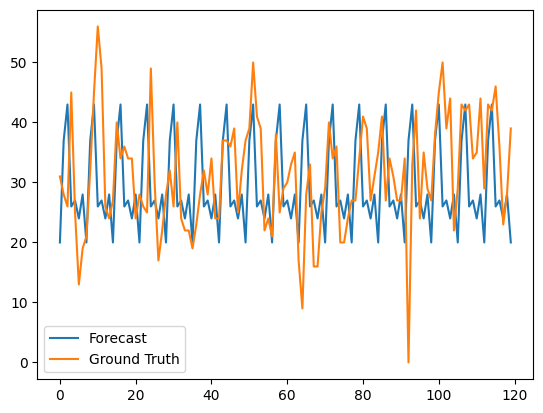

In [ ]:
test = pd.read_csv(Path("../data/STORE_1_STORE_1_587_test.csv"))

forecast = main_class.forecast(best_forecaster, 120)
forecast.reset_index(drop=True).plot()
test.cnt[:120].reset_index(drop=True).plot()
plt.legend(["Forecast", "Ground Truth"])

In [ ]:
main_class.calculate_metrics(forecast, test.cnt[:120])

/home/den/miniconda3/envs/universal-py12/lib/python3.12/site-packages/sktime/performance_metrics/forecasting/_base.py:616: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/den/miniconda3/envs/universal-py12/lib/python3.12/site-packages/sktime/performance_metrics/forecasting/_base.py:616: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


{'MAE': 8.675, 'SMAPE': 0.2919072700622117, 'R2': -0.44947129385087803}

In [ ]:
main_class.calculate_metrics(pd.Series([test.cnt[:120].mean()] * len(forecast), index=forecast.index), test.cnt[:120])

/home/den/miniconda3/envs/universal-py12/lib/python3.12/site-packages/sktime/performance_metrics/forecasting/_base.py:616: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/den/miniconda3/envs/universal-py12/lib/python3.12/site-packages/sktime/performance_metrics/forecasting/_base.py:629: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/den/miniconda3/envs/universal-py12/lib/python3.12/site-packages/sktime/performance_metrics/forecasting/_base.py:616: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/den/miniconda3/envs/universal-py12/lib/python3.12/site-packages/sktime/performance_metrics/forecasting/_ba

{'MAE': 7.4094444444444445, 'SMAPE': 0.24912093652496337, 'R2': 0.0}

# Классические статистические модели

## SARIMA

Модель SARIMA может учитывать сезонность, тренд. То есть эту модель можно применять в нестационарным рядам (в отличии от простой ARMA).  
В качестве бейзлайна классической статистической модели - хорошо подойдёт.  

Подбирать гиперпараметры (p, q, d, P, Q, D) будем стандартным способом, изученным на лекции:
   1. Графический анализ ряда
   2. Стабилизация дисперсии при необходимости
   3. Подобр порядок дифференцирования, при котором ряд становится стационарным. Таким образом фиксируются параметры d; D модели ARIMA.
   4. Построить графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF) и из этих графиков определить примерные значения параметров p; q; P; Q.
   5. Полученные модели необходимо обучить, сравнить их по информационному критерию Акаике и выбрать ту, которая его минимизирует.
   6. Оценка остатков
Пункты 1-4 были проделаны для каждого ВР в [eda.ipynb](report_1__eda.ipynb).

Из минусов можно отметить то, что подать дополнительные фичи не получится (а у нас они есть) - но это мы сделаем в модели SARIMAX.

In [ ]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.sarimax import SARIMAX
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

In [ ]:
train_val = pd.read_csv(Path("../data/STORE_1_STORE_1_064_train_val.csv"))
test = pd.read_csv(Path("../data/STORE_1_STORE_1_064_test.csv"))

In [ ]:
forecaster = NaiveForecaster(strategy="mean", sp=7)
forecaster.fit(train_val.cnt[: -365 * 2])
y_pred = forecaster.predict(fh=np.arange(1, 121))

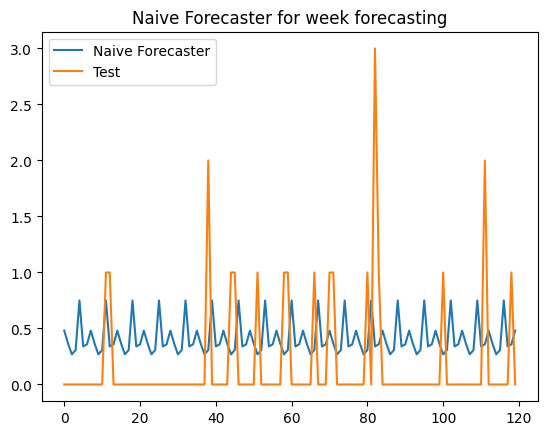

In [ ]:
y_pred.reset_index(drop=True).plot(label="Naive Forecaster")
test.cnt.reset_index(drop=True).plot(label="Test")
plt.legend()
plt.title("Naive Forecaster for week forecasting")
plt.show()

In [ ]:
evaluate(
    forecaster=NaiveForecaster(strategy="last"),
    cv=SlidingWindowSplitter(fh=np.arange(1, 121), window_length=365 * 2, step_length=25),
    y=train_val.cnt,
    scoring=MeanAbsolutePercentageError(symmetric=True),
)

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,1.622222,0.009506,0.022475,730,729
1,1.588889,0.006018,0.018339,730,754
2,0.533333,0.006466,0.016526,730,779
3,0.600000,0.004961,0.017404,730,804
4,0.600000,0.005582,0.015881,730,829
5,1.472222,0.006143,0.015794,730,854
6,0.516667,0.005169,0.016309,730,879
7,0.500000,0.004991,0.023210,730,904
8,1.587500,0.006315,0.017760,730,929
9,0.400000,0.005600,0.016301,730,954


In [ ]:
def sarima_grid_search(
    train_val: pd.DataFrame,
    cv: SlidingWindowSplitter,
    max_p: int,
    max_P: int,
    max_q: int,
    max_Q: int,
    d: int,
    D: int,
    seasonal_period: int,
):
    """
    Perform a grid search over SARIMA hyperparameters.
    """
    order = [[p, d, q] for p in range(max_p + 1) for q in range(max_q + 1)]
    seasonal_order = [[P, D, Q, seasonal_period] for P in range(max_P + 1) for Q in range(max_Q + 1)]

    gscv = ForecastingGridSearchCV(
        forecaster=SARIMAX(),
        cv=cv,
        param_grid={
            "order": order,
            "seasonal_order": seasonal_order,
        },
        n_jobs=-1,
        refit=False,
        verbose=10,
    )
    gscv.fit(train_val.cnt)
    return gscv

In [ ]:
cv = SlidingWindowSplitter(fh=np.arange(1, 8), window_length=365 * 2, step_length=100)
gscv = sarima_grid_search(train_val, cv, max_p=1, max_P=1, max_q=1, max_Q=1, d=1, D=1, seasonal_period=7)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


/home/den/miniconda3/envs/universal-py12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/den/miniconda3/envs/universal-py12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
gscv.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,1.141717e+15,0.181266,0.014145,"{'order': [0, 1, 0], 'seasonal_order': [0, 1, ...",5.0
1,1.505930e+15,1.421741,0.014272,"{'order': [0, 1, 0], 'seasonal_order': [0, 1, ...",9.0
2,1.788236e+15,0.970716,0.040134,"{'order': [0, 1, 0], 'seasonal_order': [1, 1, ...",15.0
3,1.564781e+15,2.166601,0.013941,"{'order': [0, 1, 0], 'seasonal_order': [1, 1, ...",10.0
4,1.147406e+15,1.736960,0.021481,"{'order': [0, 1, 1], 'seasonal_order': [0, 1, ...",7.0
5,1.033112e+15,3.035418,0.014718,"{'order': [0, 1, 1], 'seasonal_order': [0, 1, ...",3.0
6,1.734246e+15,3.174124,0.013310,"{'order': [0, 1, 1], 'seasonal_order': [1, 1, ...",12.0
7,1.003555e+15,4.742691,0.014959,"{'order': [0, 1, 1], 'seasonal_order': [1, 1, ...",1.0
8,1.309664e+15,0.251295,0.014792,"{'order': [1, 1, 0], 'seasonal_order': [0, 1, ...",8.0
9,1.719702e+15,1.879155,0.014668,"{'order': [1, 1, 0], 'seasonal_order': [0, 1, ...",11.0


## EMA

## SARIMAX

## Prophet

## Orbit

# Сравнение классических статистических моделей